# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# Новый раздел

# 4. Домашнее задание
***

https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding/download

In [1]:
import numpy as np
import pandas as pd
import math
#import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_mpi_reg_loc = pd.read_csv("kiva_mpi_region_locations.csv")
df_loan_theme_ids = pd.read_csv("loan_theme_ids.csv")
df_loan_themes_by_reg = pd.read_csv("loan_themes_by_region.csv")

## 4.1. Самостоятельная работа
***

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)

In [3]:
print('Страны, в которых преобладают мужчины: ')

group_country = df_kiva_loans[df_kiva_loans.borrower_genders.notna()]\
    .groupby('country')\
    .agg(is_male_more = ('borrower_genders',\
        lambda x: sum([i.count('male') - 2 * i.count('female') for i in list(x.values)]) > 0))
group_country[group_country.is_male_more].drop(columns=['is_male_more'])

Страны, в которых преобладают мужчины: 


""
country
Azerbaijan
Belize
China
Egypt
Kosovo
Lao People's Democratic Republic
Mauritania
Mongolia
Nigeria


In [4]:
print('Страны, в которых преобладают группы людей: ')

group_country = df_kiva_loans[df_kiva_loans.borrower_genders.notna()]\
    .groupby('country')\
    .agg(is_group_more = ('borrower_genders',\
        lambda x: sum([-1 if i == 'male' or i == 'female' else 1 for i in list(x.values)]) > 0))
group_country[group_country.is_group_more].drop(columns=['is_group_more'])

Страны, в которых преобладают группы людей: 


""
country
Benin
Brazil
Burkina Faso
Burundi
Cambodia
Chile
Congo
Dominican Republic
Ghana


#  
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)

In [5]:
df_kiva_loans['sex_type'] = [x if x in ['male', 'female'] else 'group'  for x in df_kiva_loans.borrower_genders]
df = df_kiva_loans.sort_values('funded_amount', ascending = False).head(100).copy()

def top_100_bar(column, string, rot = 0):
    plt.figure(figsize=(20,10))
    plt.title("Топ 100 займов " + string, fontsize=16)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=rot)
    sns.barplot(y=column.values, x=column.index, alpha=0.6)
    plt.show()

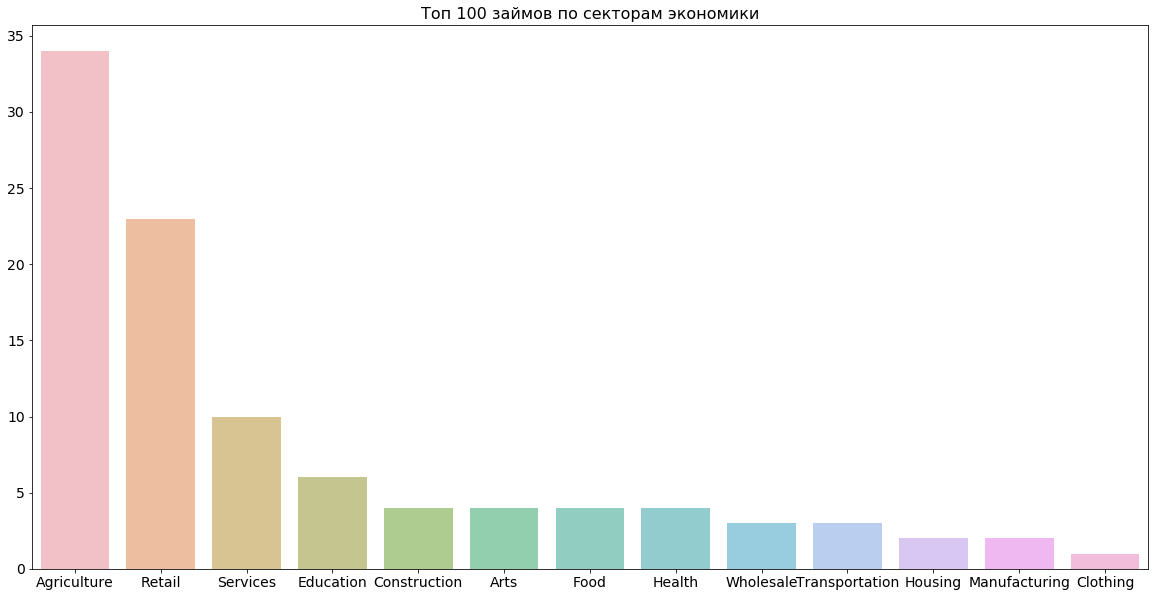

In [6]:
top_100_bar(df.sector.value_counts(), 'по секторам экономики')

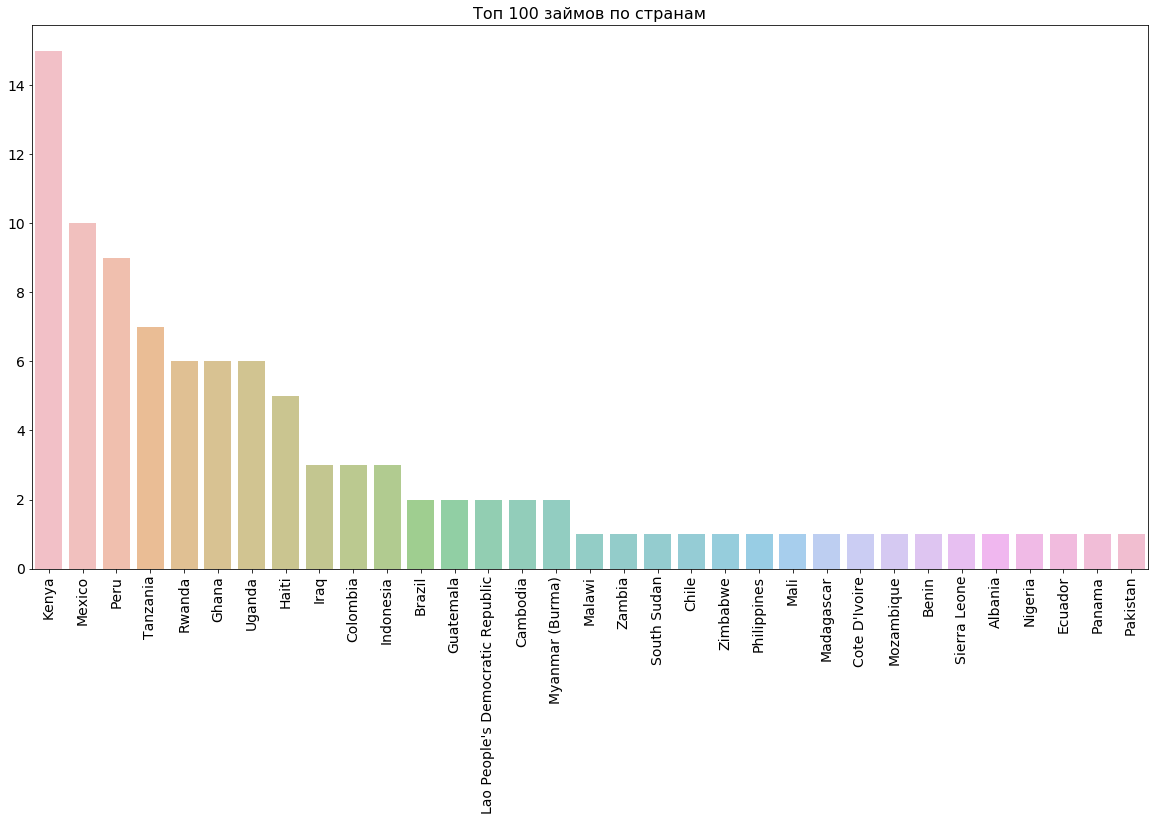

In [7]:
top_100_bar(df.country.value_counts(), 'по странам', 90)

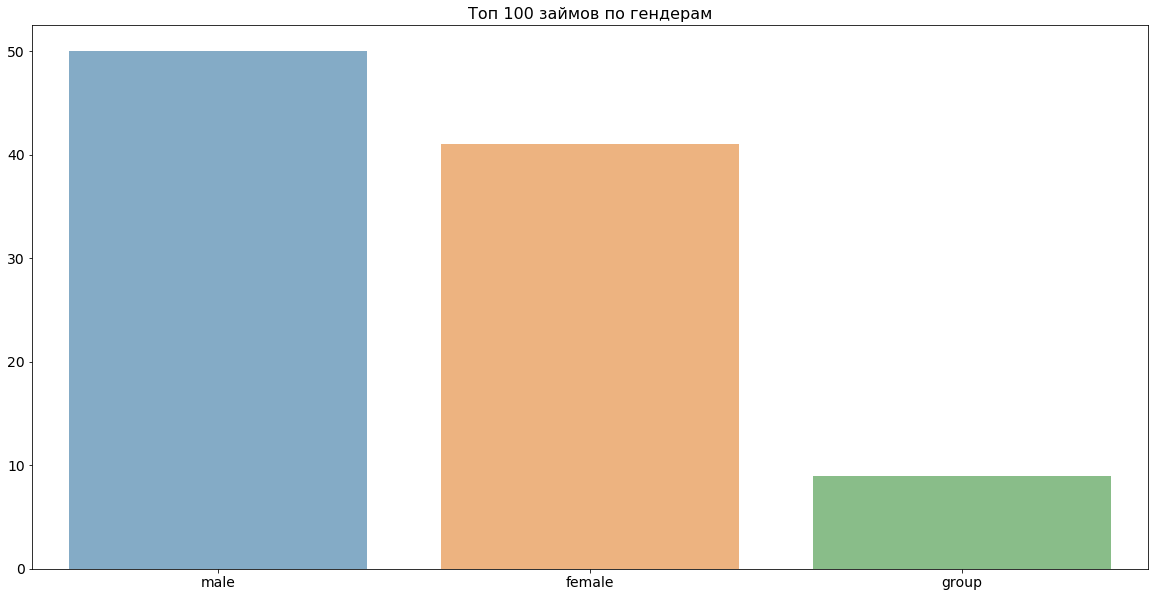

In [8]:
top_100_bar(df.sex_type.value_counts(), 'по гендерам')

## 4.2. Домашняя работа
***

Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

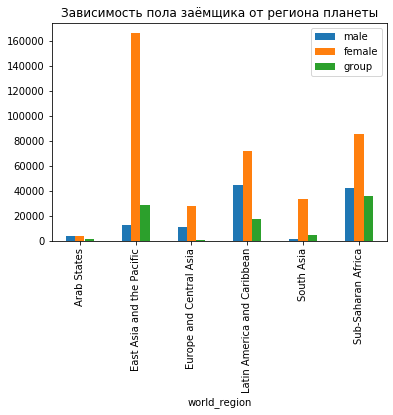

In [174]:
df_country_wr = pd.DataFrame(df_mpi_reg_loc.groupby(['country', 'world_region'])\
                             .groups.keys(), columns=['country', 'world_region']).dropna()
df = pd.merge(df_kiva_loans, df_country_wr, how='inner', on=['country'])
group_by_region = df.groupby('world_region')
df = pd.DataFrame(columns=['world_region', 'male', 'female', 'group'])
for name, group in group_by_region:
    df = df.append(group.sex_type.value_counts().T)
df.world_region = group_by_region.groups.keys()
df = df.reset_index(drop=True)
df.plot(x="world_region", y=['male', 'female', 'group'], kind="bar", title='Зависимость пола заёмщика от региона планеты')

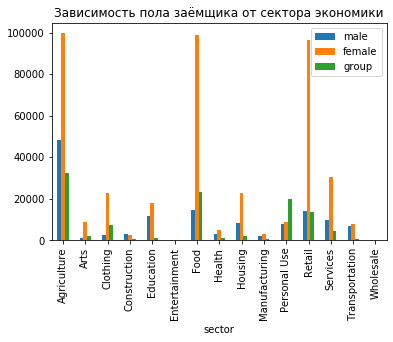

In [178]:
df = df_kiva_loans.copy()
group_by_sector = df.groupby('sector')
df = pd.DataFrame(columns=['sector', 'male', 'female', 'group'])
for name, group in group_by_sector:
    df = df.append(group.sex_type.value_counts().T)
df.sector = group_by_sector.groups.keys()
df = df.reset_index(drop=True)
df.plot(x="sector", y=['male', 'female', 'group'], kind="bar", title='Зависимость пола заёмщика от сектора экономики')

Влияние такого атрибута займа, как Количество кредиторов (lender_count), на суммы и сроки займов.

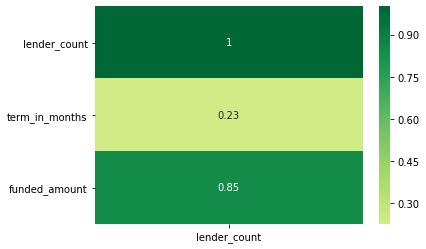

In [202]:
df = df_kiva_loans[['lender_count', 'term_in_months', 'funded_amount']]

ax = sns.heatmap(df.corr().lender_count.to_frame(), xticklabels=df.lender_count.to_frame().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5) 
plt.yticks(rotation=0)
plt.show()

Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

In [ ]:
df_mpi_grouped = df_mpi_reg_loc\
    .groupby(['country'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()

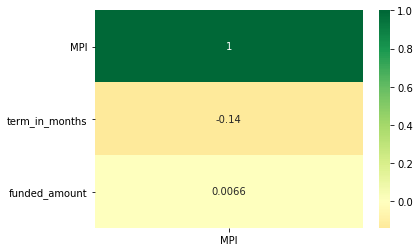

In [204]:
df = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')
df = df[['MPI', 'term_in_months', 'funded_amount']]

ax = sns.heatmap(df.corr().MPI.to_frame(), xticklabels=df.MPI.to_frame().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5) 
plt.yticks(rotation=0)
plt.show()

In [206]:
df.columns

Index(['id', 'funded_amount', 'loan_amount', 'activity', 'sector', 'use',
       'country_code', 'country', 'region', 'currency', 'partner_id',
       'posted_time', 'disbursed_time', 'funded_time', 'term_in_months',
       'lender_count', 'tags', 'borrower_genders', 'repayment_interval',
       'date', 'sex_type', 'MPI', 'monthly_repayment'],
      dtype='object')

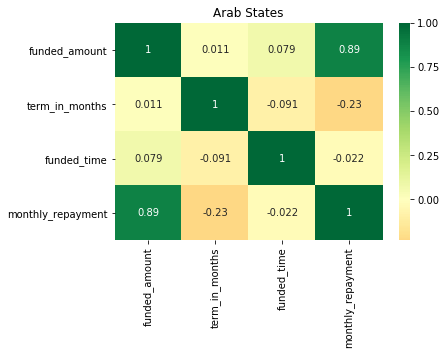

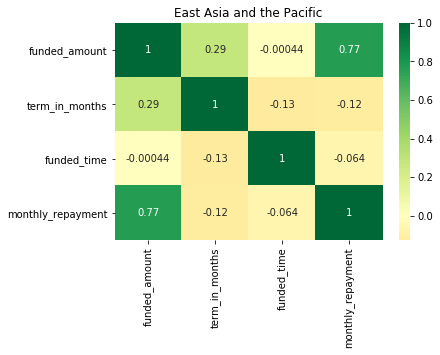

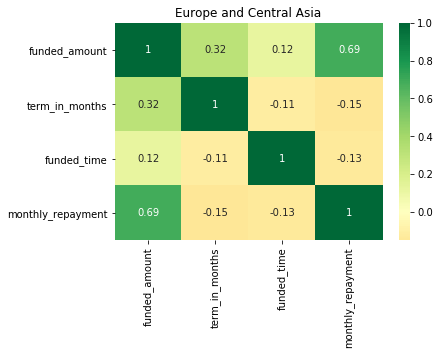

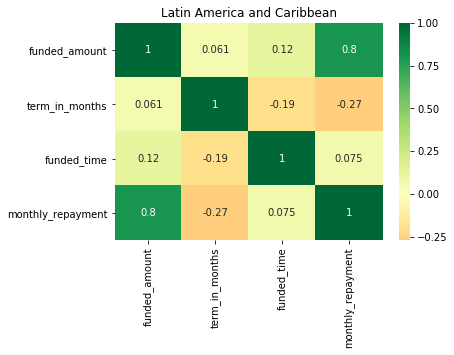

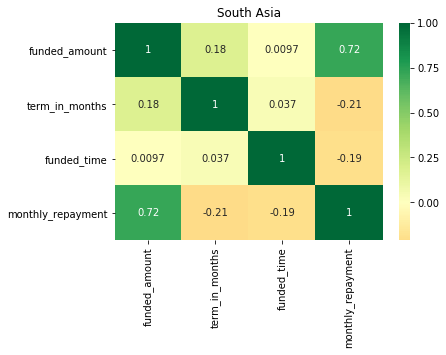

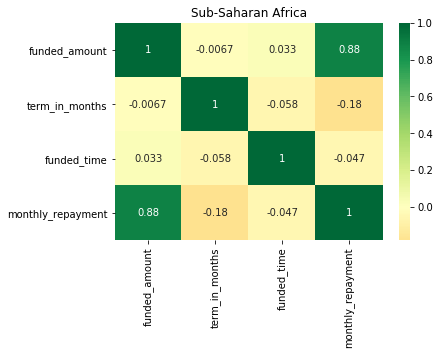

In [207]:
df_country_wr = pd.DataFrame(df_mpi_reg_loc.groupby(['country', 'world_region'])\
                             .groups.keys(), columns=['country', 'world_region']).dropna()
df = pd.merge(df_kiva_loans, df_country_wr, how='inner', on=['country'])
df['monthly_repayment'] = df['loan_amount'] / df['term_in_months']
df.funded_time = pd.to_datetime(df.funded_time).astype(np.int64)
df = df[['funded_amount', 'term_in_months', 'funded_time', 'monthly_repayment', 'world_region']]
for name, group in df.groupby('world_region'):
    correl = group.drop(columns=['world_region']).corr()
    ax = sns.heatmap(correl, xticklabels=correl.columns, yticklabels=correl.columns, cmap='RdYlGn', center=0, annot=True)
    i, k = ax.get_ylim()
    ax.set_ylim(i+0.5, k-0.5) 
    plt.yticks(rotation=0)
    plt.title(name)
    plt.show()